# Brief

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

# Data

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minutes.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

# Task

Use regression models to predict the number of days a customer rents DVDs for. Recommend a model yielding a mean squared error (MSE) less than 3 on the test set.

**Libraries**

Common

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

Sklearn

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, BayesianRidge
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV

**Data**

In [17]:
df = pd.read_csv('/Users/dani/PycharmProjects/Projects/DataCamp Projects/Predicting Movie Rental Durations/datasets/rental_info.csv')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [19]:
# tranforming our two data features into datetime
cols = ['rental_date', 'return_date']
df[cols] = df[cols].apply(pd.to_datetime, errors='coerce')

In [20]:
# creating our target feature
df['rental_length_date'] = (df['return_date'] - df['rental_date']).dt.days

In [21]:
# cleaning the special_features column
df['deleted_scenes'] = np.where(df.special_features.str.contains('Deleted Scenes'), 1, 0)
df['behind_the_scenes'] = np.where(df.special_features.str.contains('Behind the Scenes'), 1, 0)

In [22]:
df.isna().sum()

rental_date           0
return_date           0
amount                0
release_year          0
rental_rate           0
length                0
replacement_cost      0
special_features      0
NC-17                 0
PG                    0
PG-13                 0
R                     0
amount_2              0
length_2              0
rental_rate_2         0
rental_length_date    0
deleted_scenes        0
behind_the_scenes     0
dtype: int64

In [23]:
df.duplicated().sum()

0

In [24]:
df.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_date,deleted_scenes,behind_the_scenes
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287,4.525944,0.497320,0.536347
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293,2.635108,0.500009,0.498693
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100,0.000000,0.000000,0.000000
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100,2.000000,0.000000,0.000000
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100,5.000000,0.000000,1.000000
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100,7.000000,1.000000,1.000000
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100,9.000000,1.000000,1.000000


Text(0.5, 1.0, 'Correlation Map')

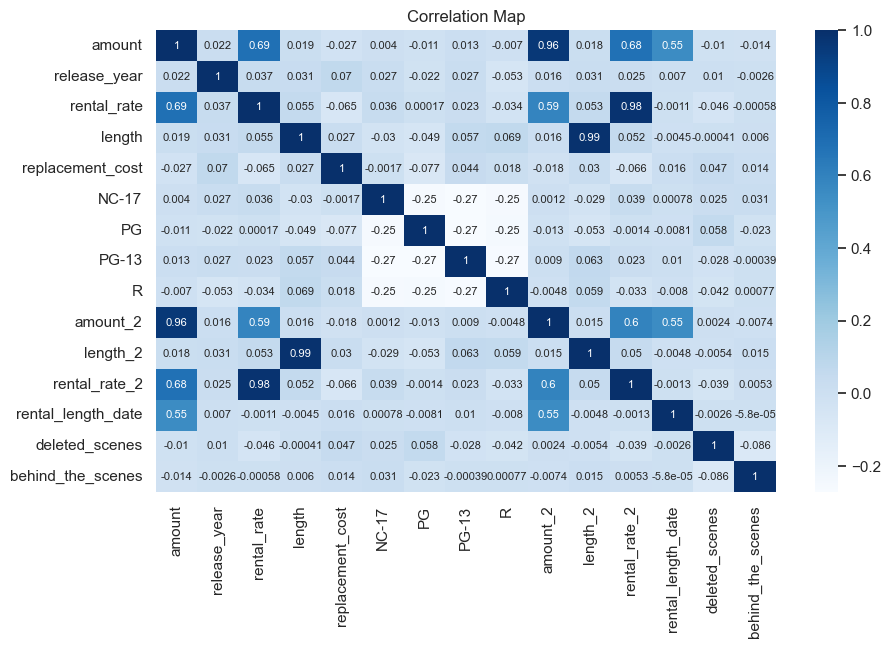

In [25]:
# quick check on correlation
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
plt.rc('font', size=8)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only = True), annot=True, cmap='Blues').set_title('Correlation Map')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   rental_date         15861 non-null  datetime64[ns, UTC]
 1   return_date         15861 non-null  datetime64[ns, UTC]
 2   amount              15861 non-null  float64            
 3   release_year        15861 non-null  float64            
 4   rental_rate         15861 non-null  float64            
 5   length              15861 non-null  float64            
 6   replacement_cost    15861 non-null  float64            
 7   special_features    15861 non-null  object             
 8   NC-17               15861 non-null  int64              
 9   PG                  15861 non-null  int64              
 10  PG-13               15861 non-null  int64              
 11  R                   15861 non-null  int64              
 12  amount_2            15861 non-nu

**Modeling**

Reproducibility

In [27]:
seed = 9

In [28]:
cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=seed)

In [29]:
X = df.drop(['rental_date', 'return_date', 'special_features', 'rental_length_date'], axis=1)
y = df.rental_length_date

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.20,
                                                   random_state=seed)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# non-boosting models to start

dm = DummyRegressor()
lr = LinearRegression()
sgd = SGDRegressor(random_state=seed)
br = BayesianRidge()
dt = DecisionTreeRegressor(random_state=seed)
rf = RandomForestRegressor(random_state=seed)

classifiers = [('DummyRegressor', dm),('LinearRegression', lr),
               ('SGDRegressor', sgd), ('BayesianRidge', br),
               ('TreeRegressor', dt),('RandomForestRegressor', rf)]

In [32]:
for clf_name, clf in classifiers:
    # fit the training set
    clf.fit(X_train_scaled, y_train)

    # label prediction
    y_pred = clf.predict(X_test_scaled)

    # evaluations
    scoring = cross_val_score(clf, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=cv, verbose=1)
    print('')
    print('{:s} Average Cross-Val (MSE) Score: {:.3f}'.format( clf_name, np.abs(scoring.mean()) ))


DummyRegressor Average Cross-Val (MSE) Score: 6.904

LinearRegression Average Cross-Val (MSE) Score: 2.850

SGDRegressor Average Cross-Val (MSE) Score: 2.857

BayesianRidge Average Cross-Val (MSE) Score: 2.850

TreeRegressor Average Cross-Val (MSE) Score: 2.306

RandomForestRegressor Average Cross-Val (MSE) Score: 2.091


Evaluation on test set

In [33]:
best_model = rf

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

best_mse = mean_squared_error(y_test, y_pred)

print('MSE:', best_mse)

MSE: 2.0305235428385586


# Conclusion

The data provided was largely preprocessed with only a few items to amend:

- Datetime conversions
- Feature engineering

Once clean, our data needed some scaling so we deployed StandardScaler to take care of that once we split the Train/Test sets into a 80%-20% split.

We iterated through a few regression models to compare our cross-validation scores on the training sets. From this, we found the lowest average score on the RandomForestRegressor. 

- We had the option to tune the hyperparameters through RandomizedSearchCV but found that we achieved a score well below our prescribed threshold. 

Overall, we recommend the usaged of the RandomForestRegressor followed by the DecisionTreeRegressor (if speed is of most importance). Tuning these further might yield better resuts but it's always recommended to think about the trade-offs involved in doing so. 